# Predicting Salesforce closing stock price with time series

The hope for this project is to practice using time series using three different approaches - ARIMA time series Analysis, Bayesian time series, and LSTM. This will probably be done in three different notebooks to limit cluttering. 

### Import libraries

In [1]:
#MCMC/ARIMA packages
import pymc3 as pm
import pmdarima as ar
import arviz as az
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#data wrangling
import pandas as pd
import numpy as np

This is just daily stock trend data for Salesforce (CRM), obtained from yahoo https://finance.yahoo.com/quote/crm/history/

In [2]:
# read in data
CRM = pd.read_csv('data/CRM_daily.csv', index_col='Date',parse_dates=True)

In [3]:
CRM.head(12)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-23,3.7500,4.3250,3.6875,4.3000,4.3000,43574400
2004-06-24,4.3875,4.4225,4.1250,4.1900,4.1900,8887200
2004-06-25,4.1275,4.1875,3.9475,3.9500,3.9500,6710000
2004-06-28,4.0000,4.0525,3.8600,4.0000,4.0000,2270800
2004-06-29,4.0000,4.1750,3.9575,4.1000,4.1000,2112000
2004-06-30,4.1000,4.2350,4.0075,4.0175,4.0175,2087600
2004-07-01,4.0200,4.0500,3.9750,4.0075,4.0075,1754800
2004-07-02,4.0250,4.2450,4.0125,4.2450,4.2450,993200
2004-07-06,4.2325,4.2500,4.1200,4.2500,4.2500,1216800


In [4]:
CRM.shape

(4441, 6)

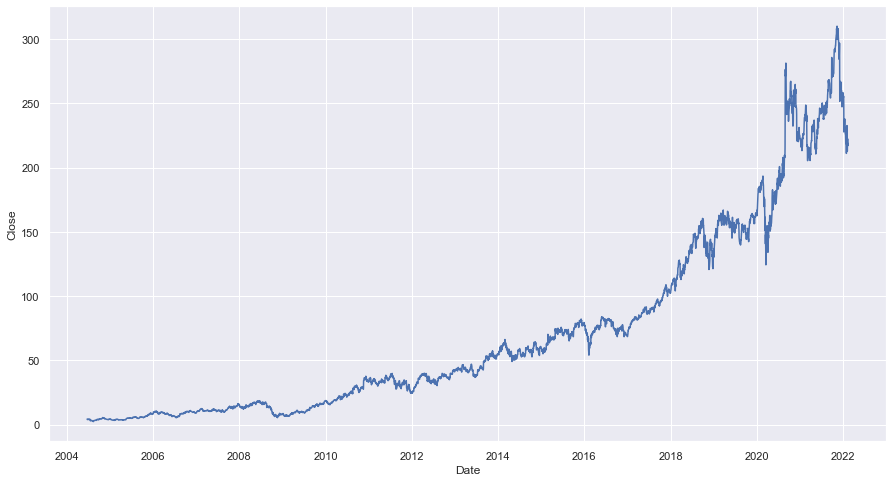

In [5]:
#plotting trend w/ non-stationary mean
sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})
p1 = sns.lineplot(
    data = CRM,
    x = "Date", y = "Close"
)

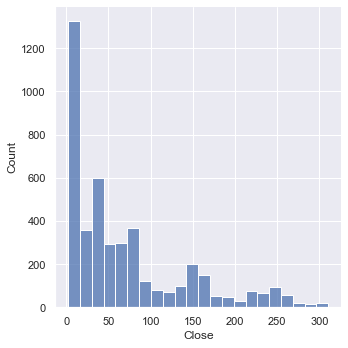

In [6]:
#show density
sns.displot(data = CRM, x="Close", binwidth = 14)

Closing price is non-normally distributed and trend is non-stationary, which is also confirmed below.

### Stationarity Check (Dickey Fuller)

In [7]:
ts_test = adfuller(CRM['Close'], autolag = 'AIC')
ts_test[1]

0.9529157133939834

The p-value is way larger than 0.05, so we do not reject the null hypothesis and thus our data is non-stationary. 

### Transformation using differences

Though the non-stationary mean issue is taken care of as part of ARIMA, I also wanted to visualize the transformation to understand what it does better, which is done below

In [8]:
CRM_stnry = CRM.diff().dropna(); CRM_stnry.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-24,0.6375,0.0975,0.4375,-0.1100,-0.1100,-34687200.0
2004-06-25,-0.2600,-0.2350,-0.1775,-0.2400,-0.2400,-2177200.0
2004-06-28,-0.1275,-0.1350,-0.0875,0.0500,0.0500,-4439200.0
2004-06-29,0.0000,0.1225,0.0975,0.1000,0.1000,-158800.0
2004-06-30,0.1000,0.0600,0.0500,-0.0825,-0.0825,-24400.0


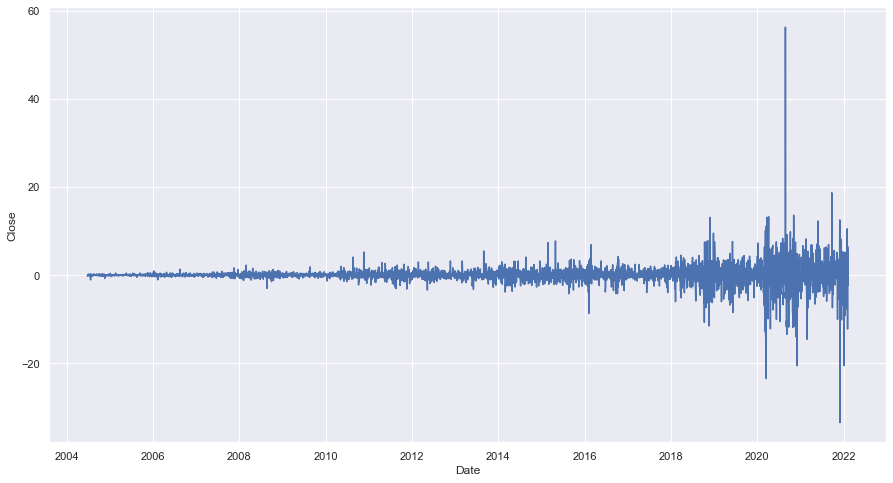

In [9]:
sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})
p2 = sns.lineplot(
    data = CRM_stnry,
    x = "Date", y = "Close"
)

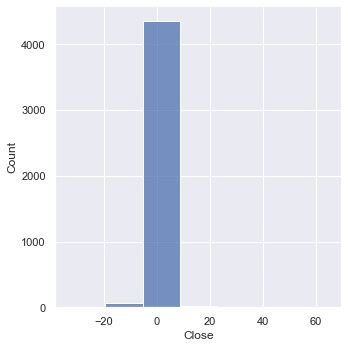

In [10]:
sns.displot(data = CRM_stnry, x="Close", binwidth = 14)

In [11]:
ts_test2 = adfuller(CRM_stnry['Close'], autolag = 'AIC')
ts_test2

(-11.284501171020382,
 1.429095098541365e-20,
 30,
 4409,
 {'1%': -3.4318340352231185,
  '5%': -2.862195763748743,
  '10%': -2.567119067159428},
 19601.313864077012)

Data is now stationary based on the ADF test, but we'll use the old data for ARIMA. The p-value is near 0 and our critical value is now much smaller at -11.3

### Modeling

In [12]:
#CRM.index = pd.DatetimeIndex(CRM.index).to_period('D')

In [13]:
test_arima_params = ar.auto_arima(CRM['Close'], trace = True, suppress_warnings = True)
test_arima_params.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19845.833, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19845.661, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19845.660, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19845.922, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19847.660, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19847.659, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19849.607, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19845.843, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 7.149 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4441
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -9919.830
Date:                Sat, 12 Feb 2022   AIC                          19845.660
Time:                        01:37:16   BIC                          19864.855
Sample:                             0   HQIC                         19852.428
                               - 4441                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0491      0.034      1.445      0.148      -0.017       0.116
ma.L1         -0.0222      0.006     -3.710      0.000      -0.034      -0.010
sigma2         5.1064      0.017    297.627      0.000       5.073       5.140
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2282772.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             125.84   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                       114.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(0,1,1) gives us the best AIC, so we'll use that in model fitting

In [14]:
# fitting our model, first w/out train/test split

#date index warning here, but still provides the same model results
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.")

    arima_model = ARIMA(CRM['Close'], order = (0,1,1))
    arima_fit = arima_model.fit()

In [15]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4441
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -9920.921
Date:                Sat, 12 Feb 2022   AIC                          19845.843
Time:                        01:37:16   BIC                          19858.640
Sample:                             0   HQIC                         19850.355
                               - 4441                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0217      0.006     -3.646      0.000      -0.033      -0.010
sigma2         5.1090      0.017    304.904      0.000       5.076       5.142
Ljung-Box (L1) (Q):                   0.00   Jarque-

Residuals are normally distributed with a mean very close to 0. 

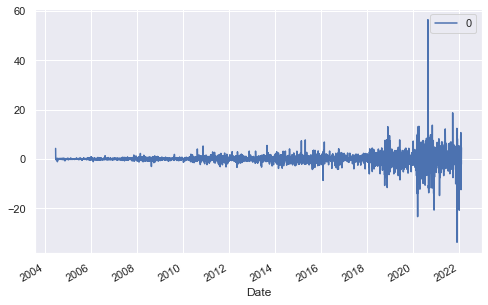

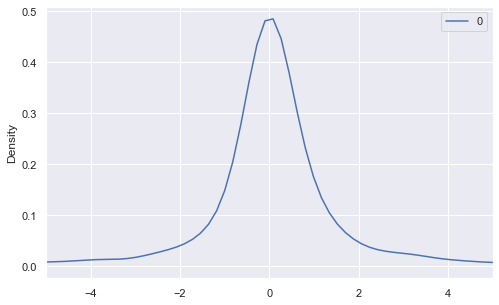

In [16]:
# view residual distributions and densities
sns.set(rc = {'figure.figsize':(8,5)})
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
residuals.plot.kde()
plt.xlim(-5, 5)
plt.show()

In [17]:
# put predicted values in a data frame, setting up for plot
arima_preds = pd.DataFrame(arima_fit.predict())
arima_preds.dtypes, CRM.dtypes, arima_preds

(predicted_mean    float64
 dtype: object,
 Open         float64
 High         float64
 Low          float64
 Close        float64
 Adj Close    float64
 Volume         int64
 dtype: object,
             predicted_mean
 Date                      
 2004-06-23        0.000000
 2004-06-24        4.300000
 2004-06-25        4.192381
 2004-06-28        3.955249
 2004-06-29        3.999031
 ...                    ...
 2022-02-03      225.164114
 2022-02-04      213.038435
 2022-02-07      219.095899
 2022-02-08      217.016044
 2022-02-09      217.421028
 
 [4441 rows x 1 columns])

<AxesSubplot:xlabel='Date', ylabel='Close'>

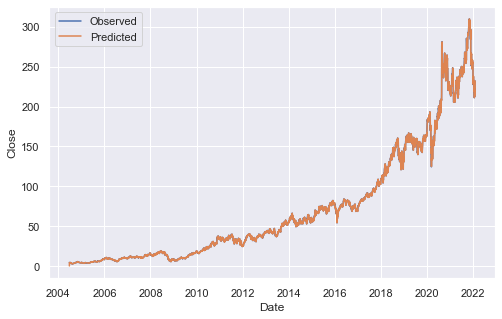

In [18]:
#predicted and observed plot
fig, axis = plt.subplots()

sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(
    data = CRM, ax=axis,
    x = "Date", y = "Close",
    label = 'Observed'
)
sns.lineplot(
    data = arima_preds, ax=axis,
    x = "Date", y = "predicted_mean",
    label = 'Predicted'
)

Zooming into a section of the plot - there are a good amount of data points, so looking at a closer scale is potentially helpful here. Of course, this isn't using a train test split at all, so this is essentially just seeing how close the fit is. I'll do a train/test split in the next section to see how the model does at predicting the last two years or so. 

<AxesSubplot:xlabel='Date', ylabel='Close'>

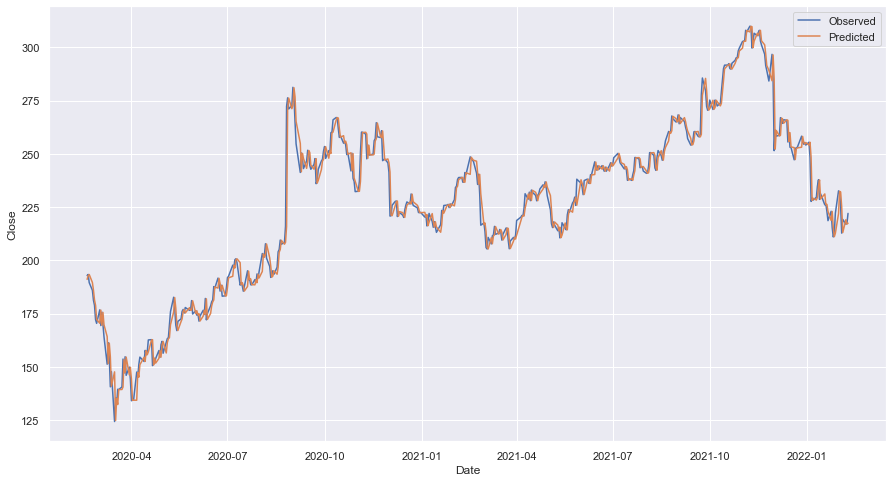

In [19]:
# zoomed in plot to show differences

arima_preds_tail = arima_preds.tail(500)
CRM_tail = CRM.tail(500)

fig, axis = plt.subplots()
sns.set(rc = {'figure.figsize':(15,6)})
sns.lineplot(
    data = CRM_tail, ax=axis,
    x = "Date", y = "Close",
    label = 'Observed'
)
sns.lineplot(
    data = arima_preds_tail, ax=axis,
    x = "Date", y = "predicted_mean",
    label = 'Predicted'
)


### Forecasting

In [28]:
# more warnings, we'll try this for now. 
CRM.index = pd.DatetimeIndex(CRM.index).to_period('D')

In [29]:
#train test split
num_rows = len(CRM)
split_size = (int)(num_rows * .85)
train = CRM.iloc[0:split_size]
test = CRM.iloc[split_size:num_rows]
print("TRAIN: %s   TEST: %s" %(train.shape, test.shape))

TRAIN: (3774, 6)   TEST: (667, 6)


In [31]:
#CRM = CRM.sort_values(by=['Date'])

fcast_model = ARIMA(train['Close'], order = (0,1,1))
fcast_fit = fcast_model.fit()
fcast_preds = fcast_fit.predict(start = split_size, end = num_rows-1)
fcast_preds.index = CRM.index[split_size:num_rows]
print(fcast_preds)

Date
2019-06-20    153.928655
2019-06-21    153.928655
2019-06-24    153.928655
2019-06-25    153.928655
2019-06-26    153.928655
                 ...    
2022-02-03    153.928655
2022-02-04    153.928655
2022-02-07    153.928655
2022-02-08    153.928655
2022-02-09    153.928655
Freq: D, Name: predicted_mean, Length: 667, dtype: float64
